<H2>Data Overview</H2>
In this competition, we need to predict if two people share a kinship relationship or not based on their facial images. The data is provided by Families In the Wild (FIW), the largest and most comprehensive image database for automatic kinship recognition.

FIW's dataset is obtained from publicly available images from celebrities.

<H2>File Descriptions </H2>

*   train-faces.zip - the training set is divided in Families (F0123), then individuals (MIDx). Images in the same MIDx folder belong to the same person. Images in the same F0123 folder belong to the same family.

* train.csv - training labels. Remember, not every individual in a family shares a kinship relationship. For example, a mother and father are kin to their children, but not to each other.

* test-faces.zip - the test set contains face images of unknown individuals

* sample_submission.csv - a sample submission file in the correct format. The column img_pair describes the pair of images, i.e., abcdef-ghijkl means the pair of images abcdef.jpg and ghijkl.jpg. Your goal is to predict if each pair of images in test-faces are related or not, where 1 means related and 0 means unrelated.
   



In [27]:
# we used VGGFace file from the below github which  has some models works better for Face Identification
!git clone https://github.com/rcmalli/keras-vggface.git

Cloning into 'keras-vggface'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 273 (delta 7), reused 7 (delta 3), pack-reused 251
Receiving objects: 100% (273/273), 6.03 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [0]:
import os,shutil
for file_ in os.listdir('keras-vggface'):
    if '.*' not in file_:
        try:
            shutil.move('keras-vggface/'+file_,'.')
        except:
            print(9) 

In [29]:
from collections import defaultdict
from glob import glob
from random import choice, sample
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import gc, psutil, cv2, random, base64, h5py, os,shutil
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999
pd.options.display.float_format = '{:20, .2f}'.format
from keras import backend as K

from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add
from keras_vggface.vggface import VGGFace
from pathlib import Path

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')
from keras.layers import Conv2D, ZeroPadding2D, Activation, concatenate
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda
import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras.layers import Conv1D, BatchNormalization,Reshape, LeakyReLU
from keras.preprocessing import image
from keras.optimizers import Adam,SGD,rmsprop
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Conv2D,MaxPooling1D,GlobalAveragePooling1D,LSTM
from keras.models import Model
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras import regularizers
%pylab inline
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [0]:
import shutil
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
# path='drive/My Drive/AAIC/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<h1>Uploading Kaggle credentials 

In [0]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


<H1>Downloading the Dataset

In [0]:
!kaggle competitions download -c recognizing-faces-in-the-wild

  0% 0.00/77.6k [00:00<?, ?B/s]
100% 77.6k/77.6k [00:00<00:00, 67.4MB/s]
 88% 30.0M/34.1M [00:00<00:00, 90.1MB/s]
100% 34.1M/34.1M [00:00<00:00, 135MB/s] 
 71% 49.0M/68.6M [00:00<00:00, 43.7MB/s]
100% 68.6M/68.6M [00:00<00:00, 100MB/s] 
  0% 0.00/156k [00:00<?, ?B/s]
100% 156k/156k [00:00<00:00, 51.7MB/s]


In [0]:
%%time
%%capture
!unzip test.zip -d test 

CPU times: user 148 ms, sys: 26.3 ms, total: 175 ms
Wall time: 3.19 s


In [0]:
print("The no of test images:",len(os.listdir('test')))

The no of test images: 6282


In [0]:
%%time
%%capture
!unzip train.zip -d train

CPU times: user 529 ms, sys: 61.9 ms, total: 591 ms
Wall time: 4.94 s


In [0]:
print("The no of train images:",len(os.listdir('train')))
# here it contains both the folders and pics

The no of train images: 470


<H1>Preparing of Data

In [0]:
train_file_path = "train_relationships.csv"
train_folders_path = "train/"
test_path = "test/"
train_df=pd.read_csv(train_file_path)
sample_sub_df=pd.read_csv('sample_submission.csv')
# The above cell contain only the variables which we change in future

In [0]:
val_famillies = "F09"
all_images = glob(train_folders_path + "*/*/*.jpg")
train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]
train_person_to_images_map = defaultdict(list)
ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]

for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]
train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

In [0]:
# all the images are of shape 224, 224, 3 as observed in EDA

<H1> Common util functions

In [0]:
def get_thumbnail(path):
    if path and os.path.exists(path):
        i = Image.open(path)
        i.thumbnail((150, 150), Image.LANCZOS)
        return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def add_image_path(x):
    image_path = 'train/' + x
    if os.path.exists(image_path):
        path = os.path.join(image_path, os.listdir(image_path)[0])
        return path

In [0]:
# https://www.kaggle.com/janpreets/just-another-feature-extractor-0-824-lb
def outer_product(x):
    """
    calculate outer-products of 2 tensors

        args 
            x
                list of 2 tensors
                , assuming each of which has shape = (size_minibatch, total_pixels, size_filter)
    """
    return keras.backend.batch_dot(
                x[0]
                , x[1]
                , axes=[1,1]
            ) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):
    """
    calculate element-wise signed square root

        args
            x
                a tensor
    """
    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):
    """
    calculate L2-norm

        args 
            x
                a tensor
    """
    return keras.backend.l2_normalize(x, axis=axis)

<H1>Common plotting error functions

In [0]:
def plot_accuracy(y):
    global curr_model_hist
    if(y == True):
        plt.plot(curr_model_hist.history['acc'])
        plt.plot(curr_model_hist.history['val_acc'])
        plt.legend(['train', 'test'], loc='lower right')
        plt.title('accuracy plot - train vs test')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    else:
        pass
    return
    
def plot_loss(y):
    global curr_model_hist
    if(y == True):
        plt.plot(curr_model_hist.history['loss'])
        plt.plot(curr_model_hist.history['val_loss'])
        plt.legend(['training loss', 'validation loss'], loc = 'upper right')
        plt.title('loss plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return

def plot_auc(y):
    global curr_model_hist
    if(y == True):
        plt.plot(curr_model_hist.history['auc'])
        plt.plot(curr_model_hist.history['val_auc'])
        plt.legend(['training auc', 'validation auc'], loc = 'upper right')
        plt.title('auc plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return

def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
    
def sol_submit(curr_model):
    submission = pd.read_csv('sample_submission.csv')
    predictions = []
    for batch in tqdm(chunker(submission.img_pair.values)):
        X1 = [x.split("-")[0] for x in batch]
        X1 = np.array([read_img(test_path + x) for x in X1])

        X2 = [x.split("-")[1] for x in batch]
        X2 = np.array([read_img(test_path + x) for x in X2])

        pred = curr_model.predict([X1, X2]).ravel().tolist()
        predictions += pred

    submission['is_related'] = predictions
    submission.to_csv("submission.csv", index=False)
    !kaggle competitions submit -c recognizing-faces-in-the-wild -f submission.csv -m "Message"    

In [0]:
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [0]:
# https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py
def preprocess_input(x, data_format=None, version=1):
    '''
    preprocess_input will take the numpy array of image and remove the unnecessary values 
    The out ut numpy only contains thermal image of face which will have the umporatant chracters
    Here we subtract the values from image numpy array after subtraction redundant pixels are removed

    '''
    x_temp = np.copy(x)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863

    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError
    return x_temp

def read_img(path):
    '''
    read_img takes the path as input and reads the data and calls the preprocess_input function which removes 
    the unnecessary pixels and gives the face relevant pixels

    '''
    img = image.load_img(path, target_size=(224, 224))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

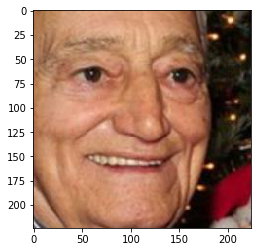

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


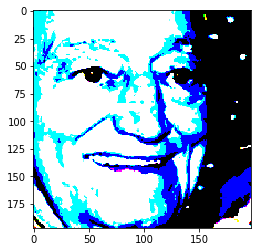

In [0]:
img=mpimg.imread('train/F0284/MID4/' + os.listdir('train/F0284/MID4')[0])
imgplot = plt.imshow(img)
plt.show()

readnp = read_img('train/F0284/MID4/' + os.listdir('train/F0284/MID4')[0])
plt.imshow(readnp)
plt.show()

In [0]:
# The above cell contain only the variables which we change in future
family_folder_names = [x for x in os.listdir(train_folders_path) if 'F' in x]
print("Total no of families :",len(family_folder_names))

all_images = glob(train_folders_path + "*/*/*.jpg")
print("Total no images inside all the folders : ",len(all_images))

samp_fam_path = train_folders_path+family_folder_names[1]
samp_img_path = os.listdir(samp_fam_path)[1]
len(os.listdir(samp_fam_path +"/"+ samp_img_path))

Total no of families : 470
Total no images inside all the folders :  12379


6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


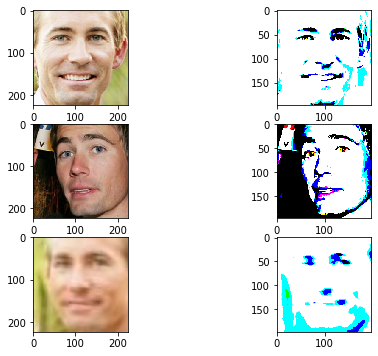

In [0]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 4
img_path = samp_fam_path +"/"+ samp_img_path +"/"
files=os.listdir(img_path)
try:
    for i in range(1, columns*rows +1,2):
        img = mpimg.imread(img_path+files[i],0)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        
        img = read_img(img_path+files[i])
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
    plt.show()
except:
    pass   

<H1>Model  Architectures

In [0]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    '''
    This function is use to generate the generators .
    It takes input of personid
    '''
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            # https://www.geeksforgeeks.org/python-numbers-choice-function/  so p1 ,p2 contains the random member id'
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])
        # the above line prints the member id if the meber doesn't exist 
        # it is just to keep a safe check                 

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])
        # X1 is a numpy array in which X1[0] is the numpy array of x[0] images after preprocessed
        #                   X1[1] is the numpy array of x[1] images after preprocessed

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        # https://pythontips.com/2013/09/29/the-python-yield-keyword-explained/
        yield [X1, X2], labels

def siamese_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))
    base_model = VGGFace(model='resnet50', include_top=False,input_shape=(224, 224, 3))

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalAvgPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])
    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])  
    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4  = Subtract()([x1_, x2_])    
    x   = Concatenate(axis=-1)([x4, x3])
    x   = Reshape(input_shape=(8192,), target_shape=(8192, 1))(x)
    
    """    x   = Conv1D(filters=100, kernel_size=3 ,strides=3,input_shape=( 8192,1),dilation_rate = 1,
                  activation= 'relu',kernel_regularizer=l2(1e-5),
                   kernel_initializer='uniform',
                 bias_initializer=initialize_bias)(x)
    x   = Conv1D( 100,3,activation= 'relu', kernel_initializer= 'he_uniform')(x)
    x   = Flatten()(x)
  
    x   = Dense(100, activation="relu")(x) 
    x   = Dropout(0.2)(x)   
    x   = Dense(128, activation="relu")(x) """
    x = Conv1D(filters=100,
               kernel_size=8,
               strides=8,input_shape=( 8192,1),
               activation='relu',
               padding='same')(x)
    x   = Conv1D( 100,8,activation= 'relu')(x)
    x   = LSTM(128, return_sequences=True)(x)
    x   = Dropout(0.1)(x)
    x   = LSTM(128, return_sequences=True)(x)
    x   = BatchNormalization ()(x)
    x   = Flatten()(x)
    x   = Dense(100, activation="relu")(x) 
    
    out = Dense(1, activation="sigmoid")(x)
    model = Model([input_1, input_2], out)
    model.compile(loss="binary_crossentropy", metrics=['acc',auc], optimizer=Adam(0.00001,decay=1e-6))
    model.summary()

    return model
 
def baseline_model():
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x = Concatenate(axis=-1)([x4, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    model.summary()

    return model

In [0]:

def inception_based_model():
    myInput = Input(shape=(96, 96, 3))

    x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = conv2d_bn(inception_3b,
                                       layer='inception_3c_3x3',
                                       cv1_out=128,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))

    inception_3c_5x5 = conv2d_bn(inception_3b,
                                       layer='inception_3c_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = conv2d_bn(inception_3c,
                                       layer='inception_4a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=192,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_4a_5x5 = conv2d_bn(inception_3c,
                                       layer='inception_4a_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(1, 1),
                                       padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = conv2d_bn(inception_4a_pool,
                                        layer='inception_4a_pool',
                                        cv1_out=128,
                                        cv1_filter=(1, 1),
                                        padding=(2, 2))
    inception_4a_1x1 = conv2d_bn(inception_3c,
                                       layer='inception_4a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = conv2d_bn(inception_4a,
                                       layer='inception_4e_3x3',
                                       cv1_out=160,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))
    inception_4e_5x5 = conv2d_bn(inception_4a,
                                       layer='inception_4e_5x5',
                                       cv1_out=64,
                                       cv1_filter=(1, 1),
                                       cv2_out=128,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = conv2d_bn(inception_4e,
                                       layer='inception_5a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e)
    inception_5a_pool = conv2d_bn(inception_5a_pool,
                                        layer='inception_5a_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1),
                                        padding=(1, 1))
    inception_5a_1x1 = conv2d_bn(inception_4e,
                                       layer='inception_5a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = conv2d_bn(inception_5a,
                                       layer='inception_5b_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = conv2d_bn(inception_5b_pool,
                                        layer='inception_5b_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = conv2d_bn(inception_5a,
                                       layer='inception_5b_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)

In [0]:
def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(
  x,
  layer=None,
  cv1_out=None,
  cv1_filter=(1, 1),
  cv1_strides=(1, 1),
  cv2_out=None,
  cv2_filter=(3, 3),
  cv2_strides=(1, 1),
  padding=None,
):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding)(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

def create_base_network(input_shape):
    mod = inception_based_model()
    new_mod = Model(mod.input,mod.layers[-5].output)
    return new_mod
def get_model5():
    input_shape = (96,96,3)
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    base_network = create_base_network(input_shape)

    # because we re-use the same instance `base_network`,
    # the weights of the network
    # will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)


    # extract features from detector
    x_detector = processed_a
    shape_detector = processed_a.shape

    # extract features from extractor , same with detector for symmetry DxD model
    shape_extractor = processed_b.shape
    x_extractor = processed_b

    # rehape to (minibatch_size, total_pixels, filter_size)
    x_detector = keras.layers.Reshape([shape_detector[1] * shape_detector[2] , shape_detector[-1]])(x_detector)
    x_extractor = keras.layers.Reshape([shape_extractor[1] * shape_extractor[2] , shape_extractor[-1]])(x_extractor)

    # outer products of features, output shape=(minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Lambda(outer_product)([x_detector, x_extractor])

    # rehape to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
    # signed square-root 

    x = keras.layers.Lambda(signed_sqrt)(x)
    # L2 normalization
    x = keras.layers.Lambda(L2_norm)(x)

    ### 
    ### attach FC-Layer
    ###

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)

    out = Dense(units=1,kernel_regularizer=keras.regularizers.l2(1e-8),kernel_initializer='glorot_normal',activation="sigmoid")(x)



    model = Model([input_a, input_b], out)

    model.compile(loss="binary_crossentropy", metrics=['acc',auc], optimizer=Adam(0.001))

    print(model.summary())

In [0]:
def vgg_model_2():
  input_1 = Input(shape=(224, 224, 3))
  input_2 = Input(shape=(224, 224, 3))

  base_model = VGGFace(model='resnet50', include_top=False)

  for layer in base_model.layers[:-3]:
      layer.trainable = True

  x1 = base_model(input_1)
  x2 = base_model(input_2)


  merged_add = Add()([x1, x2])
  merged_sub = Subtract()([x1,x2])

  merged_add = Conv2D(100 , [1,1] )(merged_add)
  merged_sub = Conv2D(100 , [1,1] )(merged_sub)

  merged = Concatenate(axis=-1)([merged_add, merged_sub])

  merged = Flatten()(merged)

  merged = Dense(100, activation="relu")(merged)
  merged = Dropout(0.3)(merged)
  merged = Dense(25, activation="relu")(merged)
  merged = Dropout(0.3)(merged)
  out = Dense(1, activation="sigmoid")(merged)

  model = Model([input_1, input_2], out)

  model.compile(loss="binary_crossentropy", metrics=['acc',auc], optimizer=Adam(0.00001))

  model.summary()

  return model

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)  

In [0]:

def vgg_model_3():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    # x1_ = Reshape(target_shape=(7*7, 2048))(x1)
    # x2_ = Reshape(target_shape=(7*7, 2048))(x2)
    #
    # x_dot = Dot(axes=[2, 2], normalize=True)([x1_, x2_])
    # x_dot = Flatten()(x_dot)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x = Multiply()([x1, x2])

    x = Concatenate(axis=-1)([x, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    model.summary()

    return model


<H1>1. Model 1 Training 

In [0]:
curr_model = baseline_model()














94699520/94694792 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_1[0][0]                    
 

In [0]:
gen_train = gen(train, train_person_to_images_map, batch_size=8)
gen_val = gen(val, val_person_to_images_map, batch_size=8)
# gen_train, gen_val are the generators

In [0]:
test_path = "test/"

checkpoint = ModelCheckpoint('model_best_checkpoint.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_on_plateau]

In [0]:
import gc
gc.collect()

curr_model_hist=curr_model.fit_generator(gen_train, use_multiprocessing=True,
                    validation_data=gen_val, epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)


Epoch 1/100
200/200 [==============================] - 68s 342ms/step - loss: 0.9521 - acc: 0.6359 - val_loss: 1.0692 - val_acc: 0.6150

Epoch 00001: val_acc improved from 0.58813 to 0.61500, saving model to vgg_face.h5
Epoch 2/100
200/200 [==============================] - 65s 327ms/step - loss: 0.7311 - acc: 0.6531 - val_loss: 0.7998 - val_acc: 0.6262

Epoch 00002: val_acc improved from 0.61500 to 0.62625, saving model to vgg_face.h5
Epoch 3/100
200/200 [==============================] - 65s 325ms/step - loss: 0.6436 - acc: 0.6709 - val_loss: 0.7346 - val_acc: 0.6481

Epoch 00003: val_acc improved from 0.62625 to 0.64812, saving model to vgg_face.h5
Epoch 4/100
200/200 [==============================] - 65s 325ms/step - loss: 0.5767 - acc: 0.7028 - val_loss: 0.6141 - val_acc: 0.7031

Epoch 00004: val_acc improved from 0.64812 to 0.70312, saving model to vgg_face.h5
Epoch 5/100
200/200 [==============================] - 64s 322ms/step - loss: 0.5605 - acc: 0.7144 - val_loss: 0.5777 - 

In [0]:
# https://www.journaldev.com/15638/python-pickle-example

# open a file, where you ant to store the data
file = open('model-1', 'wb')
# dump information to that file
pickle.dump(curr_model_hist, file)
# close the file
file.close()
shutil.copy('model-1','drive/My Drive/AAIC/north-east-smile/')

In [0]:
# open a file, where you stored the pickled data
file = open('drive/My Drive/AAIC/north-east-smile/model-1', 'rb')

# dump information to that file
curr_model_hist = pickle.load(file)

# close the file
file.close()

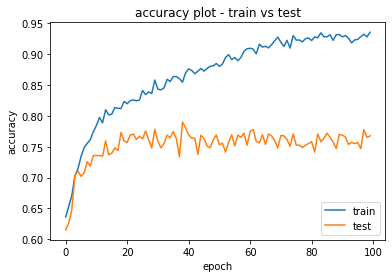

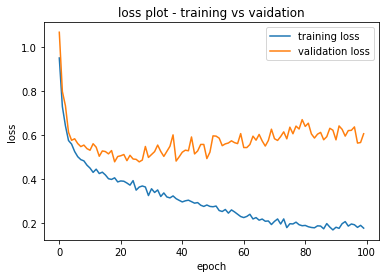

166it [43:39, 15.26s/it]


100% 247k/247k [00:01<00:00, 185kB/s]
Successfully submitted to Northeastern SMILE Lab - Recognizing Faces in the Wild

In [0]:
plot_accuracy(True)
plot_loss(True)
# plot_auc(True)
sol_submit(curr_model_hist.model)

<H1>2. Model 2 Training 

In [0]:
curr_model = vgg_model_2()

94699520/94694792 [==============================] - 1s 0us/step
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224

In [0]:
gen_train = gen(train, train_person_to_images_map, batch_size=8)
gen_val = gen(val, val_person_to_images_map, batch_size=8)
# gen_train, gen_val are the generators

In [0]:

gc.collect()

curr_model_hist=curr_model.fit_generator(gen_train, use_multiprocessing=True,
                    validation_data=gen_val, epochs=130, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)


Epoch 1/130
200/200 [==============================] - 110s 552ms/step - loss: 1.3320 - acc: 0.5384 - auc: 0.5607 - val_loss: 0.7921 - val_acc: 0.6131 - val_auc: 0.6564

Epoch 00001: val_acc improved from -inf to 0.61313, saving model to vgg_face.h5
Epoch 2/130
200/200 [==============================] - 71s 357ms/step - loss: 0.8657 - acc: 0.5609 - auc: 0.5965 - val_loss: 0.6920 - val_acc: 0.6019 - val_auc: 0.6317

Epoch 00002: val_acc did not improve from 0.61313
Epoch 3/130
200/200 [==============================] - 72s 358ms/step - loss: 0.7352 - acc: 0.5806 - auc: 0.6188 - val_loss: 0.6471 - val_acc: 0.6269 - val_auc: 0.6650

Epoch 00003: val_acc improved from 0.61313 to 0.62687, saving model to vgg_face.h5
Epoch 4/130
200/200 [==============================] - 71s 355ms/step - loss: 0.6995 - acc: 0.5994 - auc: 0.6411 - val_loss: 0.6397 - val_acc: 0.6225 - val_auc: 0.6544

Epoch 00004: val_acc did not improve from 0.62687
Epoch 5/130
200/200 [==============================] - 71s 3

In [0]:
# https://www.journaldev.com/15638/python-pickle-example

# open a file, where you ant to store the data
file = open('model-2', 'wb')
# dump information to that file
pickle.dump(curr_model_hist.history, file)
# close the file
file.close()
shutil.copy('model-2','drive/My Drive/AAIC/north-east-smile/')

In [0]:
temp={}
# open a file, where you stored the pickled data
file = open('drive/My Drive/AAIC/north-east-smile/model-2', 'rb')

# dump information to that file
temp = pickle.load(file)
# file = open('drive/My Drive/AAIC/north-east-smile/model-2.model', 'rb')
# close the file
file.close()

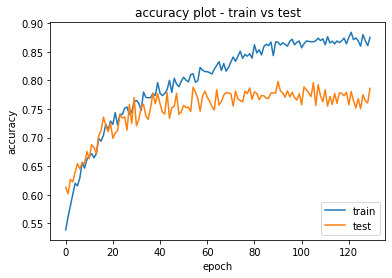

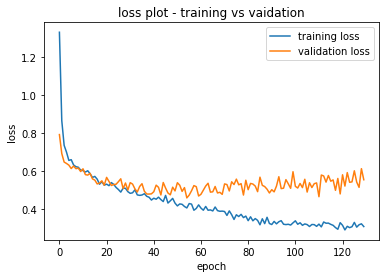

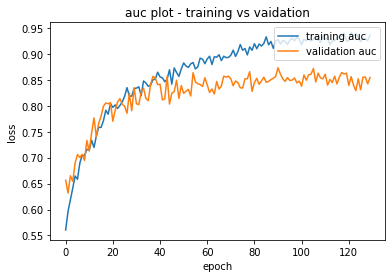

In [0]:
plot_accuracy(True)
plot_loss(True)
plot_auc(True)
# sol_submit(curr_model_hist.model)

In [0]:
sol_submit(curr_model_hist.model)

166it [43:39, 15.26s/it]
100% 247k/247k [00:01<00:00, 185kB/s]
Successfully submitted to Northeastern SMILE Lab - Recognizing Faces in the Wild


<H1> 3. Model 3 Training

In [0]:
curr_model = vgg_model_3()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]     

In [0]:
gc.collect()

curr_model_hist=curr_model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16),epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

Epoch 1/100
200/200 [==============================] - 222s 1s/step - loss: 1.7666 - acc: 0.6178 - auc: 0.6614 - val_loss: 1.9295 - val_acc: 0.5781 - val_auc: 0.6205

Epoch 00001: val_acc improved from -inf to 0.57812, saving model to vgg_face.h5
Epoch 2/100
200/200 [==============================] - 218s 1s/step - loss: 0.9592 - acc: 0.6413 - auc: 0.7081 - val_loss: 1.1416 - val_acc: 0.6125 - val_auc: 0.6606

Epoch 00002: val_acc improved from 0.57812 to 0.61250, saving model to vgg_face.h5
Epoch 3/100
200/200 [==============================] - 217s 1s/step - loss: 0.7061 - acc: 0.6769 - auc: 0.7462 - val_loss: 0.9431 - val_acc: 0.6238 - val_auc: 0.7091

Epoch 00003: val_acc improved from 0.61250 to 0.62375, saving model to vgg_face.h5
Epoch 4/100
200/200 [==============================] - 217s 1s/step - loss: 0.6072 - acc: 0.6994 - auc: 0.7754 - val_loss: 0.7891 - val_acc: 0.6494 - val_auc: 0.7134

Epoch 00004: val_acc improved from 0.62375 to 0.64938, saving model to vgg_face.h5
Epo

In [0]:
curr_model_hist.model.save('drive/My Drive/AAIC/north-east-smile/model-3')

In [0]:
temp=curr_model_hist.history
# open a file, where you ant to store the data
file = open('drive/My Drive/AAIC/north-east-smile/model-3-hist', 'wb')
# dump information to that file
pickle.dump(str(temp), file)
# close the file
file.close()

In [0]:
file = open('drive/My Drive/AAIC/north-east-smile/model-3-hist', 'rb')
# dump information to that file
history_dict=pickle.load( file)
# close the file
file.close()

In [0]:
from keras.models import load_model
curr_model_hist.history=history_dict
curr_model_hist.model=load_model('drive/My Drive/AAIC/north-east-smile/model-3',custom_objects={ 'auc': auc })

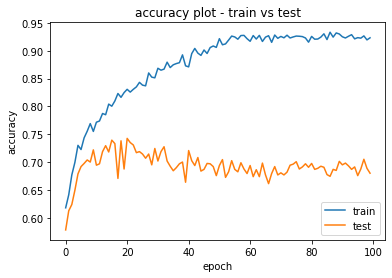

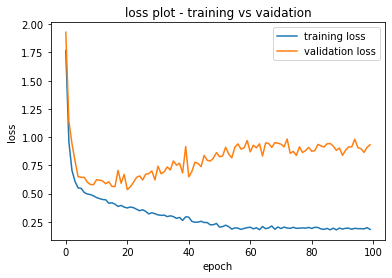

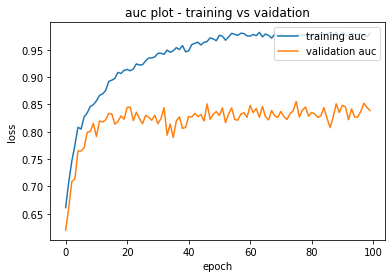

In [0]:
plot_accuracy(True)
plot_loss(True)
plot_auc(True)

In [0]:
sol_submit(curr_model_hist.model)

166it [01:59,  1.13s/it]
100% 249k/249k [00:05<00:00, 42.9kB/s]
Successfully submitted to Northeastern SMILE Lab - Recognizing Faces in the Wild


<H1>4. Model 4 training

In [0]:
curr_model = siamese_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        (None, 1, 1, 2048)   23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 2048)         0           vggface_resnet50[1][0]     

In [0]:
from keras_vggface.utils import preprocess_input

gc.collect()

curr_model_hist=curr_model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16),epochs=20, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

In [0]:
curr_model_hist.model.save('drive/My Drive/AAIC/north-east-smile/model-4')

In [0]:
temp=curr_model_hist.history
# open a file, where you ant to store the data
file = open('drive/My Drive/AAIC/north-east-smile/model-4-hist', 'wb')
# dump information to that file
pickle.dump(str(temp), file)
# close the file
file.close()

In [0]:
file = open('drive/My Drive/AAIC/north-east-smile/model-4-hist', 'rb')
# dump information to that file
history_dict=pickle.load( file)
# close the file
file.close()

In [0]:
from keras.models import load_model
curr_model_hist.history=history_dict
curr_model_hist.model=load_model('drive/My Drive/AAIC/north-east-smile/model-4',custom_objects={ 'auc': auc })

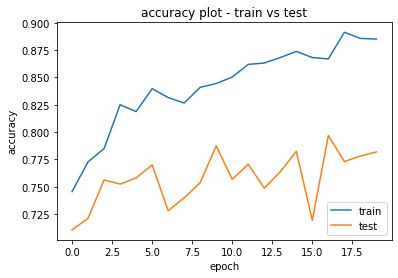

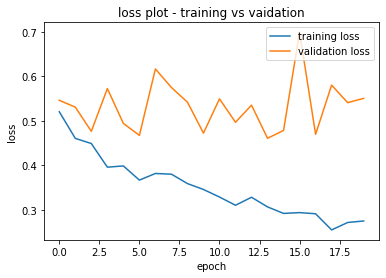

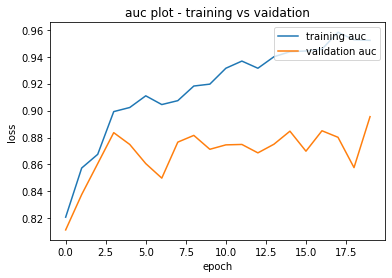

In [0]:
plot_accuracy(True)
plot_loss(True)
plot_auc(True)

In [0]:
sol_submit(curr_model_hist.model)

166it [50:57, 17.79s/it]


100% 248k/248k [00:01<00:00, 147kB/s]
Successfully submitted to Northeastern SMILE Lab - Recognizing Faces in the Wild

<H1>5. Model 5 training

In [30]:
model = get_model5()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 96, 96, 3)    0                                            
____________

In [0]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
            keras.callbacks.ModelCheckpoint('model_best_checkpoint.h5',save_best_only=True,
                                            verbose=0, save_weights_only=True,monitor='val_auc',mode='max'),
        ]

In [0]:
train_gen = gen(batch_size=16,data=train)
val_gen = gen(batch_size=16,data=val)

In [0]:
curr_model_hist=model.fit_generator(train_gen,steps_per_epoch=200,use_multiprocessing=True,
          epochs=100,validation_data=val_gen,verbose=1,
          validation_steps=100,callbacks=callbacks)

Epoch 1/100
200/200 [==============================] - 78s 392ms/step - loss: 0.6495 - acc: 0.5956 - auc: 0.6609 - val_loss: 0.6501 - val_acc: 0.6044 - val_auc: 0.6505
Epoch 2/100
200/200 [==============================] - 78s 390ms/step - loss: 0.6507 - acc: 0.5959 - auc: 0.6388 - val_loss: 0.6566 - val_acc: 0.5994 - val_auc: 0.6353
Epoch 3/100
200/200 [==============================] - 78s 390ms/step - loss: 0.6467 - acc: 0.6103 - auc: 0.6578 - val_loss: 0.6496 - val_acc: 0.5969 - val_auc: 0.6550
Epoch 4/100
200/200 [==============================] - 78s 391ms/step - loss: 0.6561 - acc: 0.5928 - auc: 0.6423 - val_loss: 0.6433 - val_acc: 0.6281 - val_auc: 0.6736
Epoch 5/100
200/200 [==============================] - 78s 389ms/step - loss: 0.6479 - acc: 0.5913 - auc: 0.6457 - val_loss: 0.6454 - val_acc: 0.6062 - val_auc: 0.6648
Epoch 6/100
200/200 [==============================] - 78s 390ms/step - loss: 0.6442 - acc: 0.6078 - auc: 0.6555 - val_loss: 0.6386 - val_acc: 0.6206 - val_auc:

In [0]:
temp=curr_model_hist.history
# open a file, where you ant to store the data
file = open('drive/My Drive/AAIC/north-east-smile/model-5-hist', 'wb')
# dump information to that file
pickle.dump(str(temp), file)
# close the file
file.close()

In [0]:
file = open('drive/My Drive/AAIC/north-east-smile/model-5-hist', 'rb')
# dump information to that file
history_dict=pickle.load( file)
# close the file
file.close()

In [0]:
from keras.models import load_model
import json
# https://stackoverflow.com/questions/39491420/python-jsonexpecting-property-name-enclosed-in-double-quotes
history_dict= history_dict.replace("\'", "\"")
curr_model_hist.history=json.loads(history_dict)
# curr_model_hist.model=load_model('drive/My Drive/AAIC/north-east-smile/model-4',custom_objects={ 'auc': auc })

In [0]:
curr_model_hist.model.save_weights('drive/My Drive/AAIC/north-east-smile/model-5')

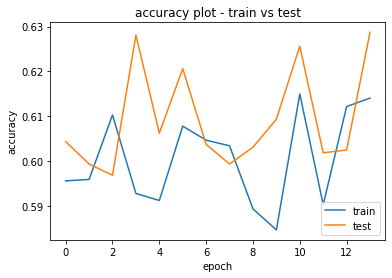

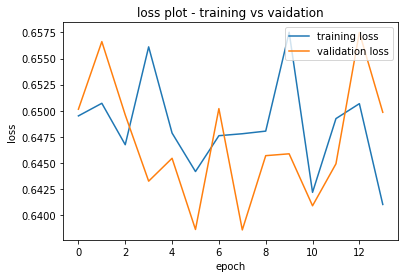

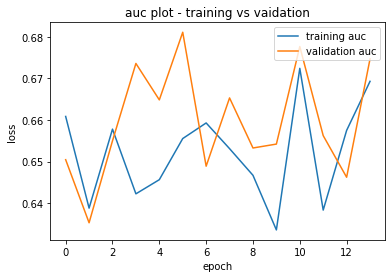

In [0]:
plot_accuracy(True)
plot_loss(True)
plot_auc(True)

In [0]:
sol_submit(curr_model_hist.model)

166it [00:33,  2.15it/s]
100% 244k/244k [00:03<00:00, 77.5kB/s]
Successfully submitted to Northeastern SMILE Lab - Recognizing Faces in the Wild


Compare to other models the model 5 performed very poorly so we will ignore the above model.

<H1> References : </H1>
Joseph P Robinson, Ming Shao, Hongfu Liu, Yue Wu, Timothy Gillis, and Yun Fu. "Visual Kinship Recognition of Families In the Wild" IEEE TPAMI Special Edition: Computational Face (2018). paper

Joseph P Robinson, Ming Shao, Handong Zhao, Yue Wu, Timothy Gillis, Yun Fu. "Recognizing Families In the Wild (RFIW): Data Challenge Workshop in conjunction with ACM MM 2017," ACM Multimedia Conference: Workshop on RFIW (2017). paper

Shuyang Wang, Joseph P Robinson, and Yun Fu. “Kinship Verification on Families in the Wild with Marginalized Denoising Metric Learning,” in IEEE Automatic Face and Gesture Recognition (2017). paper

Joseph P Robinson, Ming Shao, Yue Wu, and Yun Fu. “Families In the Wild (FIW): large-scale kinship image database and benchmarks." in ACM on Multimedia Conference (2016). paper

https://www.kaggle.com/ranjitkumar1/recognizing-face-with-one-shot-learning

https://github.com/rcmalli/keras-vggface.git



I have taken the architectures inspiration from below links:

https://www.kaggle.com/shivamsarawagi/wildimagedetection-0-875

https://www.kaggle.com/arjunrao2000/kinship-detection-with-vgg16

https://www.kaggle.com/leonbora/kinship-recognition-transfer-learning-vggface

https://www.kaggle.com/janpreets/just-another-feature-extractor-0-824-lb

https://www.kaggle.com/ranjitkumar1/recognizing-face-with-one-shot-learning?scriptVersionId=18435237